In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio

In [2]:
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DV2023/main/posts/NYCTaxi.csv").assign(
    log_trip_duration = lambda df: np.log(df.trip_duration),
    pickup_datetime = lambda df: df.pickup_datetime.apply(pd.to_datetime),
    dropoff_datetime = lambda df: df.dropoff_datetime.apply(pd.to_datetime),
    dist = lambda df: np.sqrt((df.pickup_latitude-df.dropoff_latitude)**2 + (df.pickup_longitude-df.dropoff_longitude)**2),
    #---#
    vendor_id = lambda df: df.vendor_id.map({1:'A',2:'B'})
).assign(
    speed = lambda df: df.dist / df.trip_duration,
    pickup_hour = lambda df: df.pickup_datetime.dt.hour,
    dropoff_hour = lambda df: df.dropoff_datetime.dt.hour,
    dayofweek = lambda df: df.pickup_datetime.dt.dayofweek
)
df_small = df[::100].reset_index(drop=True)

In [6]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'log_trip_duration', 'dist', 'speed', 'pickup_hour',
       'dropoff_hour', 'dayofweek'],
      dtype='object')

In [58]:
tidydata = df.pivot_table(index='pickup_hour', columns='dayofweek', values='speed', aggfunc = 'mean')\
.stack().reset_index().rename({0: 'sum of speed_mean'},axis=1)

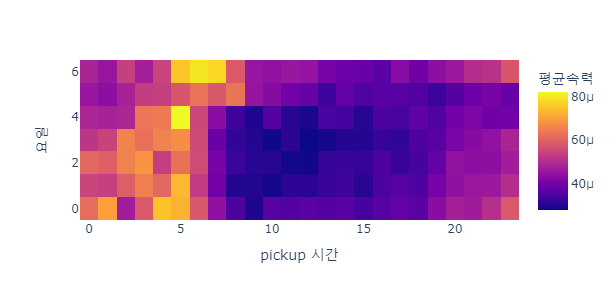

In [59]:
fig = px.density_heatmap(
    data_frame=tidydata,
    x='pickup_hour',
    y='dayofweek',
    z='sum of speed_mean',
    nbinsx=24,
    nbinsy=7,
    height=300
)
# fig.update_traces(colorbar=dict(title='평균속력'))
# fig.update_xaxes(title_text='pickup 시간')
# fig.update_yaxes(title_text='요일')

fig.update_layout(xaxis={'title':'pickup 시간'},
                 yaxis={'title':'요일'},
                 coloraxis_colorbar={'title':'평균속력'})

In [60]:
tidydata2 = df.pivot_table(index='pickup_hour', columns='dayofweek', values='dist', aggfunc = 'mean')\
.stack().reset_index().rename({0: 'sum of dist_mean'},axis=1)

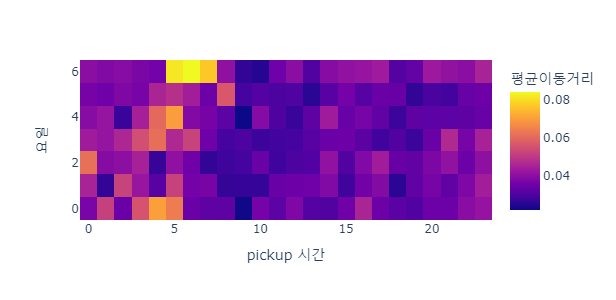

In [62]:
fig = px.density_heatmap(
    data_frame=tidydata2,
    x='pickup_hour',
    y='dayofweek',
    z='sum of dist_mean',
    nbinsx=24,
    nbinsy=7,
    height=300
)
# fig.update_traces(colorbar=dict(title='평균속력'))
# fig.update_xaxes(title_text='pickup 시간')
# fig.update_yaxes(title_text='요일')

fig.update_layout(xaxis={'title':'pickup 시간'},
                 yaxis={'title':'요일'},
                 coloraxis_colorbar={'title':'평균이동거리'})

In [64]:
df_small.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,dist,speed,pickup_hour,dropoff_hour,dayofweek
0,id2875421,B,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.120297,0.017680,0.000039,17,17,0
1,id3667993,B,2016-01-03 04:18:57,2016-01-03 04:27:03,1,-73.980522,40.730530,-73.997993,40.746220,N,486,6.186209,0.023482,0.000048,4,4,6
2,id2002463,B,2016-01-14 12:28:56,2016-01-14 12:37:17,1,-73.965652,40.768398,-73.960068,40.779308,N,501,6.216606,0.012256,0.000024,12,12,3
3,id1635353,B,2016-03-04 23:20:58,2016-03-04 23:49:29,5,-73.985092,40.759190,-73.962151,40.709850,N,1711,7.444833,0.054412,0.000032,23,23,4
4,id1850636,A,2016-02-05 00:21:28,2016-02-05 00:52:24,1,-73.994537,40.750439,-74.025719,40.631100,N,1856,7.526179,0.123345,0.000066,0,0,4


In [78]:
pcol = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'pickup_hour']
dcol = ['dropoff_datetime', 'dropoff_longitude', 'dropoff_latitude', 'dropoff_hour']
def transform(df):
    pickup = df.loc[:,['id']+pcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'pickup')
    dropoff = df.loc[:,['id']+dcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'dropoff')
    return pd.concat([pickup,dropoff],axis=0)
df_left = df_small.drop(pcol+dcol,axis=1)
df_right = pd.concat([transform(df) for i, df in df_small.groupby('id')]).reset_index(drop=True)
df_feature_small2 = df_left.merge(df_right)
df_feature_small2.head()

,id,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,log_trip_duration,dist,speed,dayofweek,datetime,longitude,latitude,hour,type
0,id2875421,B,1,N,455,6.120297,0.017680,0.000039,0,2016-03-14 17:24:55,-73.982155,40.767937,17,pickup
1,id2875421,B,1,N,455,6.120297,0.017680,0.000039,0,2016-03-14 17:32:30,-73.964630,40.765602,17,dropoff
2,id3667993,B,1,N,486,6.186209,0.023482,0.000048,6,2016-01-03 04:18:57,-73.980522,40.730530,4,pickup
3,id3667993,B,1,N,486,6.186209,0.023482,0.000048,6,2016-01-03 04:27:03,-73.997993,40.746220,4,dropoff
4,id2002463,B,1,N,501,6.216606,0.012256,0.000024,3,2016-01-14 12:28:56,-73.965652,40.768398,12,pickup


In [94]:
tidydata3 = df_feature_small2.assign(speed_cut = pd.qcut(df_feature_small2['speed'], 4,labels=['매우느림','조금느림','조금빠름','매우빠름']))\
.sort_values('speed_cut')

tidydata3

,id,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,log_trip_duration,dist,speed,dayofweek,datetime,longitude,latitude,hour,type,speed_cut
291,id0503659,B,2,N,1020,6.927558,0.024626,0.000024,1,2016-04-19 18:23:09,-73.966103,40.804832,18,dropoff,매우느림
111,id0616736,B,2,N,884,6.784457,0.002722,0.000003,1,2016-01-19 10:34:51,-73.971390,40.761749,10,dropoff,매우느림
110,id0616736,B,2,N,884,6.784457,0.002722,0.000003,1,2016-01-19 10:20:07,-73.969322,40.763519,10,pickup,매우느림
107,id0833022,B,1,N,347,5.849325,0.008204,0.000024,1,2016-04-19 22:37:27,-73.949951,40.790588,22,dropoff,매우느림
106,id0833022,B,1,N,347,5.849325,0.008204,0.000024,1,2016-04-19 22:31:40,-73.952431,40.798409,22,pickup,매우느림
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,id1322047,A,1,N,3948,8.280964,0.242210,0.000061,3,2016-06-16 10:04:16,-74.000694,40.737282,10,pickup,매우빠름
231,id3666656,B,2,N,3428,8.139732,0.242049,0.000071,3,2016-03-24 15:35:26,-73.993401,40.753098,15,dropoff,매우빠름
230,id3666656,B,2,N,3428,8.139732,0.242049,0.000071,3,2016-03-24 14:38:18,-73.776688,40.645287,14,pickup,매우빠름
143,id3100200,A,1,N,192,5.257495,0.010408,0.000054,0,2016-03-07 12:00:45,-73.960869,40.775898,12,dropoff,매우빠름


/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



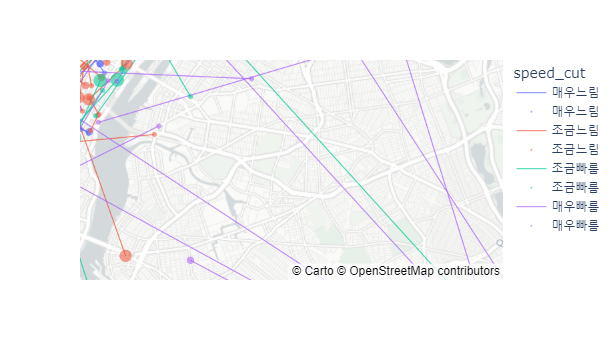

In [95]:
fig = px.line_mapbox(
    data_frame=tidydata3,
    lat = 'latitude',
    lon = 'longitude',
    line_group = 'id',
    color = 'speed_cut',
    center = {'lat':40.7322, 'lon':-73.9052},
    #---#
    mapbox_style = 'carto-positron',
    zoom=11,   
)
scatter_data = px.scatter_mapbox(
    data_frame=tidydata3,
    lat = 'latitude',
    lon = 'longitude',
    size = 'passenger_count',
    size_max = 10,
    color = 'speed_cut',
    #---#
    mapbox_style = 'carto-positron',
    zoom=10,
    width = 750,
    height = 600    
).data 
for sd in scatter_data: 
    fig.add_trace(sd)
fig.update_traces(
    line={
        'width':1
    },
    opacity=0.8
)
fig.show(config={'scrollZoom':False})